In [1]:
import sys
sys.path.append("/home/huaqingj/MyResearch/TVDN")

In [2]:
from pyTVDN import TVDNDetect
from pathlib import Path
from scipy.io import loadmat
from scipy.signal import detrend
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from pprint import pprint
import pickle
from easydict import EasyDict as edict
import warnings
from pyTVDN.TVDNutils import *
from pyTVDN.utils import in_notebook
if in_notebook():
    from tqdm import tqdm_notebook as tqdm
else:
    from tqdm import tqdm

class TVDNDetect1(TVDNDetect):
    def __init__(self, Ymat, ReconXmat, numStep=10, smoothType="Bspline", dataType=None, 
                 saveDir=None, showProgress=True, **paras):
        """
        Input:
            Ymat: The data matrix, d x n
            dataType: real data type, fMRI or MEG
            saveDir: Dir to save the results, if not specified, not save
            paras: Other parameters. There are default valuesi but you may specify these parameters manually.
               Inlcuding:
                    kappa: The parameter of penalty in MBIC
                    Lmin: The minimal length between 2 change points
                    r: The rank setted beforehand, in most cases, r=rAct. If we have non-complex singular values, r < rAct
                    MaxM: int, maximal number of change point 
                    lamb: The smooth parameter for B-spline
                    downRate: The downsample factor, determine how many Ai matrix to contribute to estimate the eigen values/vectors.
                    decimateRate: Mainly for MEG data. The rate to decimate from MEG data.
                    T: The time course
                    is_detrend: Whether detrend data or not
                    fct: The factor to adjust h when estimating A matrix
                    fName:  The file name when saving the results
                    freq: The parameter used drawing the eigen values plots
        """
        self.Ymat = Ymat
        self.paras = edict()
        if dataType is not None:
            self.dataType = dataType.lower()
        else:
            self.dataType = dataType

        if smoothType is not None:
            self.smoothType = smoothType.lower()
        else:
            self.smoothType = smoothType


        if self.dataType == "meg":
            self.paras.kappa = 2.65
            self.paras.Lmin = 60
            self.paras.r = 6
            self.paras.MaxM = 19
            self.paras.lamb = 1e-4
            self.paras.downRate = 20
            self.paras.decimateRate = 10
            self.paras.T = 2
            self.paras.is_detrend = False
            self.paras.fct = 0.5
            self.paras.fName = "MEG"
            self.paras.freq = 60
            self.paras.nbasis = 10
        elif self.dataType == "fmri":
            self.paras.kappa = 2.65
            self.paras.Lmin = 4
            self.paras.r = 6
            self.paras.MaxM = 10
            self.paras.lamb = 1e-4
            self.paras.downRate = 4
            self.paras.decimateRate = None
            self.paras.T = 2
            self.paras.is_detrend = False
            self.paras.fct = 0.5
            self.paras.fName = "fMRI"
            self.paras.freq = 0.5
            self.paras.nbasis = 10
        else:
            self.paras.kappa = 2.65
            self.paras.Lmin = 4
            self.paras.r = 6
            self.paras.MaxM = 19
            self.paras.lamb = 1e-6
            self.paras.downRate = 4
            self.paras.decimateRate = None
            self.paras.T = 2
            self.paras.is_detrend = False
            self.paras.fct = 1
            self.paras.fName = "simu"
            self.paras.freq = 180
            self.paras.nbasis = 10
        keys = list(self.paras.keys())
        for key in paras.keys():
            self.paras[key] = paras[key]
        if showProgress:
            print("The parameters for detection are:")
            pprint(self.paras)
        
        if saveDir is not None:
            self.saveDir = Path(saveDir)
            if not self.saveDir.exists():
                self.saveDir.mkdir()
        else:
            self.saveDir = saveDir
            
        self.numStep = numStep
        self.ReconXmat = ReconXmat
        self.showProgress = showProgress
        self.nYmat = None
        self.Xmat = None
        self.dXmat = None
        self.time = None
        self.midRes = None
        self.nXmat = None
        self.ndXmat = None
        self.Amat = None
        self.finalRes = None
        self.RecYmatAll = None
        self.RecResCur = None
        self.numchgs = None
        self.ecpts = None
        self.canpts = None
    
    
    def SmoothEst(self):
        if self.nYmat is None:
            self._Preprocess()
        d, n = self.nYmat.shape
        acTime = n / self.paras.freq
        self.ptime = np.linspace(0, acTime, n)
        self.time = np.linspace(0, self.paras.T, n)
        divNum = 100
        if self.smoothType == "bspline":
            self.dXmat = np.zeros((d, n))
            self.Xmat = np.zeros((d, n))
            if n%divNum == 0:
                numLoop = int(n/divNum)
            else:
                numLoop = int(n/divNum) + 1
            for i in range(numLoop):
                if (i+1)*divNum <= n:
                    low = i*divNum
                    up = (i+1)*divNum
                else:
                    low = i*divNum
                    up = n
                self.dXmat[:, low:up], self.Xmat[:, low:up] = GetBsplineEst(self.nYmat[:, low:up], self.time[low:up], 
                                                                            lamb=self.paras.lamb)
        elif self.smoothType == "fourier":
            self.dXmat, self.Xmat = GetFourierEst(self.nYmat, self.time, nbasis=self.paras.nbasis)
            
    def GetRecResCur(self):
        numchg = len(self.ecpts)
        if self.RecYmatAll is not None:
            self.RecResCur = self.RecYmatAll[numchg]
        elif self.saveDir is not None:
            RecYmatAllPath = self.saveDir/f"{self.paras.fName}_Rank{self.paras.r}_RecAll.pkl"
            if RecYmatAllPath.exists():
                with open(RecYmatAllPath, "rb") as f:
                    self.RecYmatAll = pickle.load(f)
                self.RecResCur = self.RecYmatAll[numchg]
            else:
                MaxM = self.paras.MaxM
                r = self.paras.r
                finalRes = self.finalRes
                midRes = self.midRes
                _, n = midRes.nXmat.shape
                time = np.linspace(0, self.paras.T, n)
                tStep = np.diff(time)[0]
                ndXmat = midRes.ndXmat
                nXmat = midRes.nXmat
                kpidxs = midRes.kpidxs
                eigVecs = midRes.eigVecs
                self.RecResCur = self.ReconXmat(finalRes.chgMat[numchg-1, :numchg], ndXmat, nXmat, kpidxs, eigVecs, self.Xmat, 
                                                tStep, r=r, numStep=self.numStep, is_full=True) 
        else:
            MaxM = self.paras.MaxM
            r = self.paras.r
            finalRes = self.finalRes
            midRes = self.midRes
            _, n = midRes.nXmat.shape
            time = np.linspace(0, self.paras.T, n)
            tStep = np.diff(time)[0]
            ndXmat = midRes.ndXmat
            nXmat = midRes.nXmat
            kpidxs = midRes.kpidxs
            eigVecs = midRes.eigVecs
            self.RecResCur = self.ReconXmat(finalRes.chgMat[numchg-1, :numchg], ndXmat, nXmat, kpidxs, eigVecs, self.Xmat, 
                                            tStep, r=r, numStep=self.numStep, is_full=True) 
    
    def GetRecYmats(self):
        if self.RecYmatAll is None:
            RecYmatAll = []
            MaxM = self.paras.MaxM
            r = self.paras.r
            finalRes = self.finalRes
            midRes = self.midRes
            _, n = midRes.nXmat.shape
            time = np.linspace(0, self.paras.T, n)
            tStep = np.diff(time)[0]
            ndXmat = midRes.ndXmat
            nXmat = midRes.nXmat
            kpidxs = midRes.kpidxs
            eigVecs = midRes.eigVecs
            if self.showProgress:
                pbar = tqdm(range(MaxM+1))
                for numchg in pbar:
                    pbar.set_description(f"Kappa Tuning")
        #            print(f"Current number of change point is {numchg}.")
                    if numchg == 0:
                        RecResCur = self.ReconXmat([], ndXmat, nXmat, kpidxs, eigVecs, self.Xmat, tStep, r=r,
                                                   numStep=self.numStep, is_full=True) 
                    else:
                        RecResCur = self.ReconXmat(finalRes.chgMat[numchg-1, :numchg], ndXmat, nXmat, kpidxs, eigVecs, self.Xmat, tStep, r=r, 
                                                   numStep=self.numStep, is_full=True) 
                    RecYmatAll.append(RecResCur)
            else:
                for numchg in range(MaxM+1):
                    if numchg == 0:
                        RecResCur = self.ReconXmat([], ndXmat, nXmat, kpidxs, eigVecs, self.Xmat, tStep, r=r, numStep=self.numStep, is_full=True) 
                    else:
                        RecResCur = self.ReconXmat(finalRes.chgMat[numchg-1, :numchg], ndXmat, nXmat, kpidxs, eigVecs, self.Xmat,
                                                   tStep, r=r, numStep=self.numStep, is_full=True) 
                    RecYmatAll.append(RecResCur)
            self.RecYmatAll = RecYmatAll
    
    
    def PlotRecCurve1(self, is_est=True, numP=3000, idxs=None, bestK=None, quantiles=None, saveFigPath=None, is_imag=False, is_bsp=False):
        """
        idxs: The indices of the sequences to plot 
        bestK: The best K fitted curves to plot according to the errors
        quantiles: The fitted sequences to plot according to the quantiles of errors.
        (priority: idxs > bestK > quantiles)_
        """
        assert self.finalRes is not None, "Run main function first!"
        if idxs is not None and (bestK is not None or quantiles is not None):
            warnings.warn("idxs is provided, so bestK or quantiles will be ignored", UserWarning)
        if idxs is None and bestK is not None and quantiles is not None:
            warnings.warn("bestK is provided, so quantiles will be ignored", UserWarning)
        if self.RecResCur is None:
            self.GetRecResCur()
        if is_imag:
            RecYmatCur = self.RecResCur.EstXmatImag
        else:
            RecYmatCur = self.RecResCur.EstXmatReal
        d, n = self.nYmat.shape
        if idxs is not None:
            assert d>=np.max(idxs) & np.min(idxs)>=0, "Wrong index!"
        else:
            diff = RecYmatCur - self.nYmat
            errs2 = np.sum(diff**2, axis=1)/np.sum(self.nYmat**2, axis=1)
            errs = np.sqrt(errs2)
            argidxs = np.argsort(errs)
            if quantiles is None and bestK is None:
                qidxs = np.quantile(np.arange(d), [0, 0.25, 0.5, 0.75, 1]).astype(np.int)
            elif bestK is not None:
                qidxs = argidxs[:bestK]
            else:
                qidxs = np.quantile(np.arange(d), quantiles).astype(np.int)
            idxs = argidxs[qidxs]
        if self.showProgress:
            print(f"The plot indices are {idxs}.")
        
        
        numSubPlot = len(idxs)
        numRow = ((numSubPlot-1) // 3) + 1
        
        plt.figure(figsize=[15, 5*numRow])

        for i, idx, in enumerate(idxs):
            plt.subplot(numRow, 3, i+1)
            if not is_imag:
                plt.plot(self.ptime[:numP], self.nYmat[idx, :numP], "-", label="Observed")
            if is_est:
                plt.plot(self.ptime[:numP], RecYmatCur[idx, :numP], "-.", label="Reconstructed")
            if is_bsp:
                if self.Xmat is None:
                    self.SmoothEst()
                plt.plot(self.ptime[:numP], self.Xmat[idx, :numP], "r--", label="B-spline Estimator")
            plt.legend()
        if saveFigPath is None:
            plt.show() 
        else:
            plt.savefig(saveFigPath)
            
        return idxs

In [4]:
from scipy.linalg import expm
# Reconstruct with Exp form
def ReconXmatNewBspStep(ecpts, ndXmat, nXmat, kpidxs, eigVecs, Ymat, tStep, r, numStep=30, is_full=False):
    """
    Input: 
        ecpts: Estimated change points, 
        ndXmat: a rAct x n matrix
        nXmat: a rAct x n matrix
        kpidxs: The intermedian output when calculating ndXmat, nXmat
        eigVecs: The matrix of eigen vectors of A matrix, d x d
        Ymat: The matrix to construct, d x n 
        tStep: The time step
        r: The rank setted beforehand, in most cases, r=rAct. If we have non-complex singular values, r < rAct
        if_full: Where outputing full info or not

    Return:
        Estimated Xmat, d x n
    """
    #print(f"The class calls the new reconstruction function, ReconXmatNewBspStep")
    rAct, n = ndXmat.shape
    d, _ = Ymat.shape
    ecptsfull = np.concatenate(([0], ecpts, [n])) - 1
    ecptsfull = ecptsfull.astype(np.int)
    numchgfull = len(ecptsfull)

    ResegS = np.zeros((numchgfull-1, r), dtype=np.complex)
    for  itr in range(numchgfull-1):
        lower = ecptsfull[itr] + 1
        upper = ecptsfull[itr+1] + 1
        Ycur = ndXmat[:, lower:upper]
        Xcur = nXmat[:, lower:upper]
        lams = np.zeros(r, dtype=np.complex) + np.inf
        for j in range(int(rAct/2)):
            tY = Ycur[(2*j):(2*j+2), :]
            tX = Xcur[(2*j):(2*j+2), :]
            corY = tY.dot(tX.T)
            corX = np.trace(tX.dot(tX.T))
            a = np.trace(corY)/corX
            b = (corY[1, 0] - corY[0, 1])/corX
            lams[kpidxs[j]] = a + b*1j
        tmpIdx = np.where(lams==np.inf)[0]
        lams[tmpIdx] = np.conjugate(lams[tmpIdx-1])
        ResegS[itr, :] = lams
    
    LamMs = np.zeros((r, n), dtype=np.complex)
    LamMs[:, 0] = ResegS[0, :]
    for itr in range(1, numchgfull):
        lower = ecptsfull[itr-1] + 1
        upper = ecptsfull[itr] + 1
        LamMs[:, lower:upper] = ResegS[itr-1, ].reshape(-1, 1)
    
    EstXmat = np.zeros((d, n), dtype=np.complex)
    EstXmat[:, 0] = Ymat[:, 0]
    invEigVecsr = inv(eigVecs)[:r, :]
    eigVecsr = eigVecs[:, :r]
    Amats = []
    for i in range(1, n):
        LamMat = np.diag(LamMs[:, i])
        Amat = eigVecsr.dot(LamMat).dot(invEigVecsr)
        Amats.append(Amat)
        if i%numStep==0:
            #EstXmat[:, i] = expm(Amat*tStep).dot(Ymat[:,i-1])
            EstXmat[:, i] = Amat.dot(Ymat[:, i-1]) * tStep + Ymat[:,i-1]
        else:
            #EstXmat[:, i] = expm(Amat*tStep).dot(EstXmat[:,i-1])
            EstXmat[:, i] = Amat.dot(EstXmat[:, i-1]) * tStep + EstXmat[:,i-1]
    if is_full:
        ReDict = edict()
        ReDict.EstXmatReal = detrend(EstXmat.real)
        ReDict.EstXmatRealOrg = EstXmat.real
        ReDict.EstXmatImag = EstXmat.imag
        ReDict.LamMs = LamMs
        ReDict.Amats = Amats
        return ReDict
    else:
        return detrend(EstXmat.real)

In [5]:
def ReconXmatNewBspStepNM(ecpts, ndXmat, nXmat, kpidxs, eigVecs, Ymat, tStep, r, numStep=30, is_full=False):
    """
    Input: 
        ecpts: Estimated change points, 
        ndXmat: a rAct x n matrix
        nXmat: a rAct x n matrix
        kpidxs: The intermedian output when calculating ndXmat, nXmat
        eigVecs: The matrix of eigen vectors of A matrix, d x d
        Ymat: The matrix to construct, d x n 
        tStep: The time step
        r: The rank setted beforehand, in most cases, r=rAct. If we have non-complex singular values, r < rAct
        if_full: Where outputing full info or not

    Return:
        Estimated Xmat, d x n
    """
    #print(f"The class calls the new reconstruction function, ReconXmatNewBspStep for new model")
    rAct, n = ndXmat.shape
    d, _ = Ymat.shape
    ecptsfull = np.concatenate(([0], ecpts, [n])) - 1
    ecptsfull = ecptsfull.astype(np.int)
    numchgfull = len(ecptsfull)

    ResegS = np.zeros((numchgfull-1, r), dtype=np.complex)
    for  itr in range(numchgfull-1):
        lower = ecptsfull[itr] + 1
        upper = ecptsfull[itr+1] + 1
        Ycur = ndXmat[:, lower:upper]
        Xcur = nXmat[:, lower:upper]
        lams = np.zeros(r, dtype=np.complex) + np.inf
        for j in range(int(rAct/2)):
            tY = Ycur[(2*j):(2*j+2), :]
            tX = Xcur[(2*j):(2*j+2), :]
            corY = tY.dot(tX.T)
            corX = np.trace(tX.dot(tX.T))
            a = np.trace(corY)/corX
            b = (corY[1, 0] - corY[0, 1])/corX
            lams[kpidxs[j]] = a + b*1j
        tmpIdx = np.where(lams==np.inf)[0]
        lams[tmpIdx] = np.conjugate(lams[tmpIdx-1])
        ResegS[itr, :] = lams
    
    LamMs = np.zeros((r, n), dtype=np.complex)
    LamMs[:, 0] = ResegS[0, :]
    for itr in range(1, numchgfull):
        lower = ecptsfull[itr-1] + 1
        upper = ecptsfull[itr] + 1
        LamMs[:, lower:upper] = ResegS[itr-1, ].reshape(-1, 1)
    
    EstXmat = np.zeros((d, n), dtype=np.complex)
    EstXmat[:, 0] = Ymat[:, 0]
    invEigVecsr = inv(eigVecs)[:r, :]
    eigVecsr = eigVecs[:, :r]
    Amats = []
    for i in range(1, n):
        LamMat = np.diag(LamMs[:, i])
        Amat = eigVecsr.dot(LamMat).dot(invEigVecsr)
        Amats.append(Amat)
        if i%numStep==0:
            EstXmat[:, i] = Amat.dot(Ymat[:, i-1]) 
        else:
            EstXmat[:, i] = Amat.dot(EstXmat[:, i-1])
    if is_full:
        ReDict = edict()
        ReDict.EstXmatReal = detrend(EstXmat.real)
        ReDict.EstXmatRealOrg = EstXmat.real
        ReDict.EstXmatImag = EstXmat.imag
        ReDict.LamMs = LamMs
        ReDict.Amats = Amats
        return ReDict
    else:
        return detrend(EstXmat.real)

In [6]:
def TVDNRankTuning(ranks, kappas, Ymat, ReconXmat, numStep=10, smoothType="Bspline", dataType=None, saveDir=None, **paras):
    """
    Input:
        ranks: The range of ranks to tune
        kappas: The range of kappas to tune
        Ymat: The data matrix, d x n
        dataType: real data type, fMRI or MEG
        saveDir: Dir to save the results, if not specified, not save
        paras: Other parameters. There are default values but you may specify these parameters manually.
            Inlcuding:
            Lmin: The minimal length between 2 change points
            MaxM: int, maximal number of change point 
            lamb: The smooth parameter for B-spline
            downRate: The downsample factor, determine how many Ai matrix to contribute to estimate the eigen values/vectors.
            decimateRate: Mainly for MEG data. The rate to decimate from MEG data.
            T: The time course
            is_detrend: Whether detrend data or not
            fct: The factor to adjust h when estimating A matrix
            fName:  The file name when saving the results
            plotfct: The factor to adjust the time course when plotting
            freq: The parameter used drawing the eigen values plots
    Return:
        A dict containing:
            1. Optimal rank in the given ranks
            2. Optimal kappa in the given kappas
            3. The detection object under the optimal rank and kappa
            4. The minimal MSE in the given ranks and kappas
    """

    try:
        len(kappas)
    except:
        kappas = [kappas]
    kappas = np.array(kappas)

    kappaCur = kappas[0]
    paras["kappa"] = kappaCur

    MSEs = []
    optKappasCur = []
    cMSE = np.Inf
    cDetection = None
    MSEsKappas = []
    for rank in ranks:
        #print("="*50)
        #print(f"The current rank is {rank}.")
        paras["r"] = rank
        detection = TVDNDetect1(Ymat=Ymat, ReconXmat=ReconXmat, numStep=numStep, smoothType=smoothType, 
                                dataType=dataType, saveDir=saveDir, showProgress=False, **paras)
        detection()
        if len(kappas) == 1:
            MSE = detection.GetCurMSE()
            optKappaCur = kappaCur
        else:
            detection.TuningKappa(kappas)
            MSEKappas = [detection.MSEs[i] for i in detection.numchgs]

            #optMSECur = np.min(detection.MSEs)
            #optNum = np.argmin(detection.MSEs)

            optKappaCur = kappas[MSEKappas==np.min(MSEKappas)]
            optKappaOptNumChg = detection.numchgs[np.argmin(MSEKappas)]
            MSE = detection.MSEs[optKappaOptNumChg]

        MSEs.append(MSE)
        MSEsKappas.append(MSEKappas)
        optKappasCur.append(optKappaCur)
        if cMSE >= MSE:
            del cDetection
            cDetection = detection 
            cMSE = MSE
        else:
            del detection
            
        #print("="*50)

    optRank = ranks[np.argmin(MSEs)]
    optKappa = optKappasCur[np.argmin(MSEs)]
    #if len(kappas) != 1:
    #    cDetection.UpdateEcpts()

    Res = edict()
    Res.MSEs = MSEs
    Res.MSEsKappas = MSEsKappas
    Res.minErr = np.min(MSEs)
    Res.optRank = optRank
    Res.optKappa = optKappa
    return Res

In [7]:
resDir = Path("../results")
dataDir = Path("../data")

In [8]:
filname = Path("fMRI_samples.mat")
fMRIs = loadmat(dataDir/filname)["clean_subjects"]
fMRI = fMRIs[0, 9]["fMRI"][:90, :]

In [9]:
from scipy.signal import lfilter, firls, decimate
fs = 0.5 #sampling frequency
fmin = 0.009 # 
fmax = 0.08
hbp = firls(21, np.array([0, 0.02, 0.04, 0.06, 0.08, 0.1])*2/fs,
           desired = np.array([0, 0, 1, 1, 0, 0])) 

# rank tuning
ranks = [2, 4, 6, 8, 10]
kappas = np.arange(0.01, 4, 0.01)

In [10]:
#_, numLoop = fMRIs.shape
#results = []
#for i in tqdm(range(numLoop)):
#    result = {}
#    cfMRI = fMRIs[0, i]["fMRI"][:90, :]
#    chpffMRI= lfilter(hbp, 1, cfMRI)
#    tuningRes = TVDNRankTuning(ranks=ranks, kappas=kappas, Ymat=chpffMRI, ReconXmat=ReconXmatNewBspStep, 
#                     numStep=1, smoothType="Bspline", 
#                     dataType="fMRI", saveDir=None, Lmin=4, downRate=4, fct=1, T=2, MaxM=20, 
#                     fName="fMRI_HPF", kappa=2.65, freq=0.5,
#                     lamb=1e-8, decimateRate=None, is_detrend=True)
#    #MSEs = np.array(tuningRes.MSEsKappas)
#    #rIdx, kappaIdx = np.unravel_index(np.argmin(MSEs),MSEs.shape)
#    #optRank = ranks[rIdx]
#    #optKappa = kappas[kappaIdx]
#    #cfMRIDet = TVDNDetect1(Ymat=chpffMRI, ReconXmat=ReconXmatNewBspStep, numStep=1, 
#    #                    saveDir=None, dataType="fMRI", Lmin=4, downRate=4, fct=1, T=2, MaxM=20, 
#    #                    fName="fMRI_HPF", r=optRank, kappa=optKappa, freq=0.5, lamb=1e-8,
#    #                      decimateRate=None, is_detrend=True)
#    #cfMRIDet()
#    #cfMRIDet.TuningKappa(kappas)
#    
#    result["rankRes"] = tuningRes
#    #result["detObj"] = cfMRIDet
#    results.append(result)

In [11]:
#with open("./fMRIsRankTuningResults.pkl", "wb") as f:
#    pickle.dump(results, f)

In [12]:
with open("../results/fMRIsRankTuningResults.pkl", "rb") as f:
    results = pickle.load(f)

# Demo result 1

In [13]:
idx = 10

cfMRI = fMRIs[0, idx]["fMRI"][:90, :]
chpffMRI= lfilter(hbp, 1, cfMRI)

result = results[idx]
tuningRes = result["rankRes"]
MSEs = np.array(tuningRes.MSEsKappas)
rIdx, kappaIdx = np.unravel_index(np.argmin(MSEs),MSEs.shape)
optRank = ranks[rIdx]
optKappa = kappas[kappaIdx]

cfMRIDet = TVDNDetect1(Ymat=chpffMRI, ReconXmat=ReconXmatNewBspStep, numStep=1, 
                        saveDir=None, dataType="fMRI", Lmin=4, downRate=4, fct=1, T=2, MaxM=20, 
                        fName="fMRI_HPF", r=optRank, kappa=optKappa, freq=0.5, lamb=1e-8,
                          decimateRate=None, is_detrend=True)
cfMRIDet()
cfMRIDet.TuningKappa(kappas)

The parameters for detection are:
{'Lmin': 4,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 4,
 'fName': 'fMRI_HPF',
 'fct': 1,
 'freq': 0.5,
 'is_detrend': True,
 'kappa': 2.23,
 'lamb': 1e-08,
 'nbasis': 10,
 'r': 2}


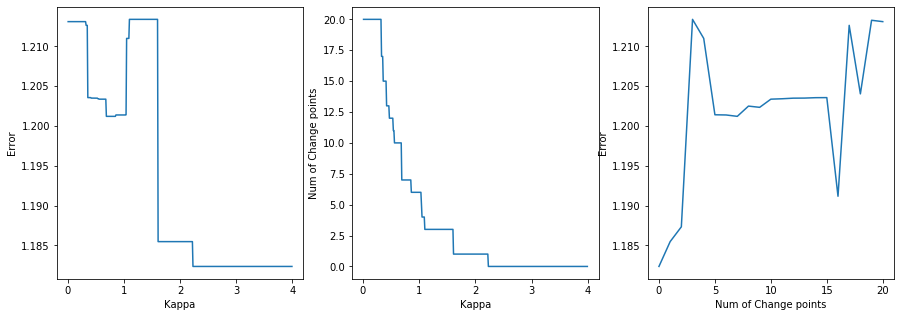

In [14]:
cfMRIDet.PlotKappaErrCurve()

The plot indices are [85 46 87 55  2].


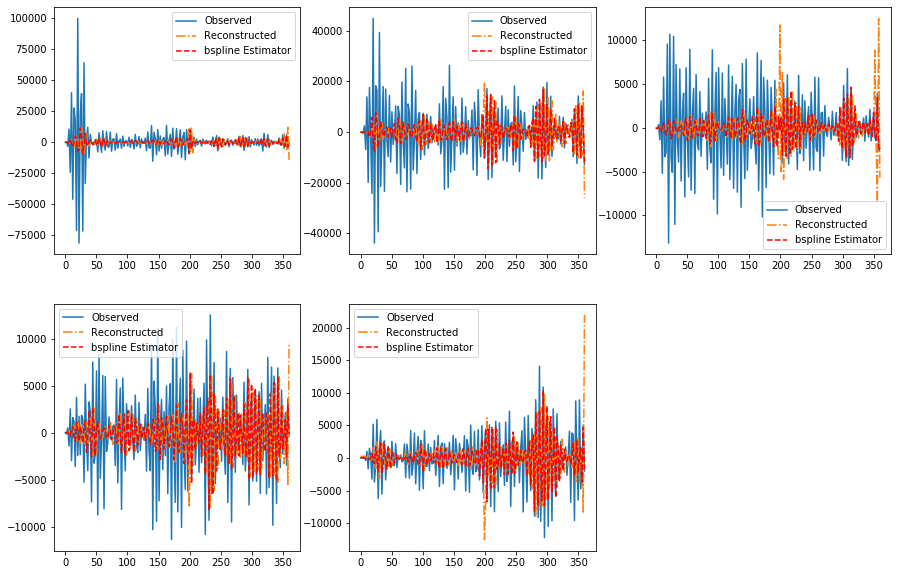

In [15]:
cfMRIDet.UpdateEcpts(16)
idxs = cfMRIDet.PlotRecCurve(is_smoothCurve=1)

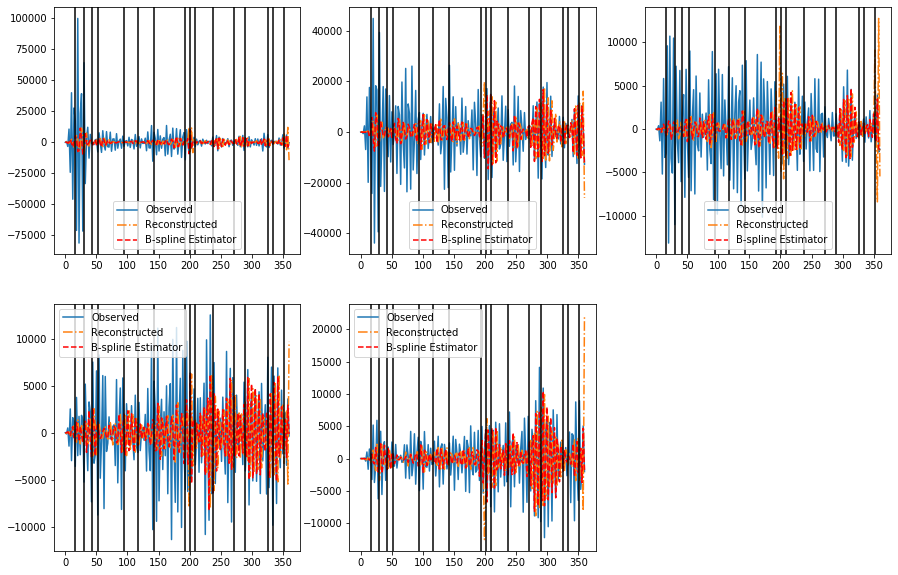

In [16]:
ecpts = cfMRIDet.ecpts
ecpts = ecpts.astype(np.int)
plt.figure(figsize=[15, 5*2])
for i, idx, in enumerate(idxs):
    plt.subplot(2, 3, i+1)
    plt.plot(cfMRIDet.ptime[:], cfMRIDet.nYmat[idx, :], "-", label="Observed")
    plt.plot(cfMRIDet.ptime[:], cfMRIDet.RecResCur.EstXmatRealOrg[idx, :], "-.", label="Reconstructed")
    plt.plot(cfMRIDet.ptime[:], cfMRIDet.Xmat[idx, :], "r--", label="B-spline Estimator")
    plt.legend()
    for ecpt in ecpts:
        plt.axvline(cfMRIDet.ptime[:][ecpt], color="black", label="Change Point")

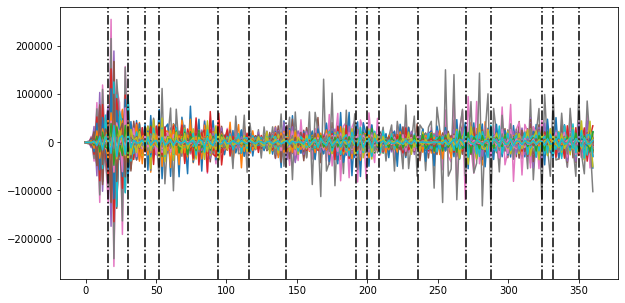

In [17]:
cfMRIDet.PlotEcpts()

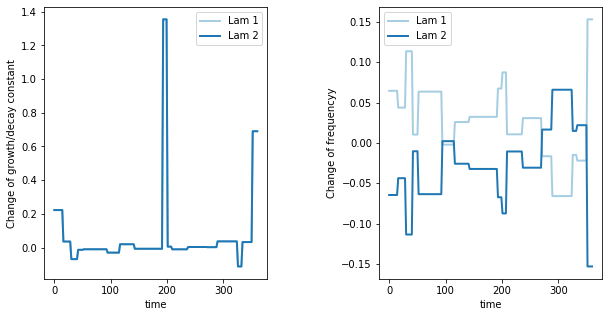

In [18]:
cfMRIDet.PlotEigenCurve()

# Demo result 2

In [19]:
idx = 100

cfMRI = fMRIs[0, idx]["fMRI"][:90, :]
chpffMRI= lfilter(hbp, 1, cfMRI)

result = results[idx]
tuningRes = result["rankRes"]
MSEs = np.array(tuningRes.MSEsKappas)
rIdx, kappaIdx = np.unravel_index(np.argmin(MSEs),MSEs.shape)
optRank = ranks[rIdx]
optKappa = kappas[kappaIdx]

cfMRIDet = TVDNDetect1(Ymat=chpffMRI, ReconXmat=ReconXmatNewBspStep, numStep=1, 
                        saveDir=None, dataType="fMRI", Lmin=4, downRate=4, fct=1, T=2, MaxM=20, 
                        fName="fMRI_HPF", r=optRank, kappa=optKappa, freq=0.5, lamb=1e-8,
                          decimateRate=None, is_detrend=True)
cfMRIDet()
cfMRIDet.TuningKappa(kappas)

The parameters for detection are:
{'Lmin': 4,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 4,
 'fName': 'fMRI_HPF',
 'fct': 1,
 'freq': 0.5,
 'is_detrend': True,
 'kappa': 1.51,
 'lamb': 1e-08,
 'nbasis': 10,
 'r': 2}


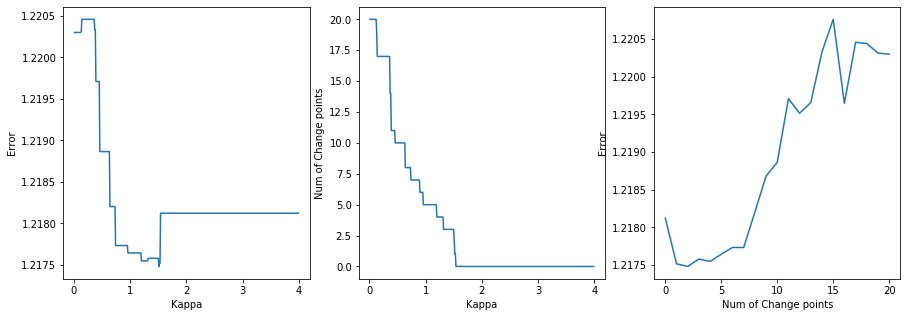

In [20]:
cfMRIDet.PlotKappaErrCurve()

The plot indices are [18 17 25 75 58].


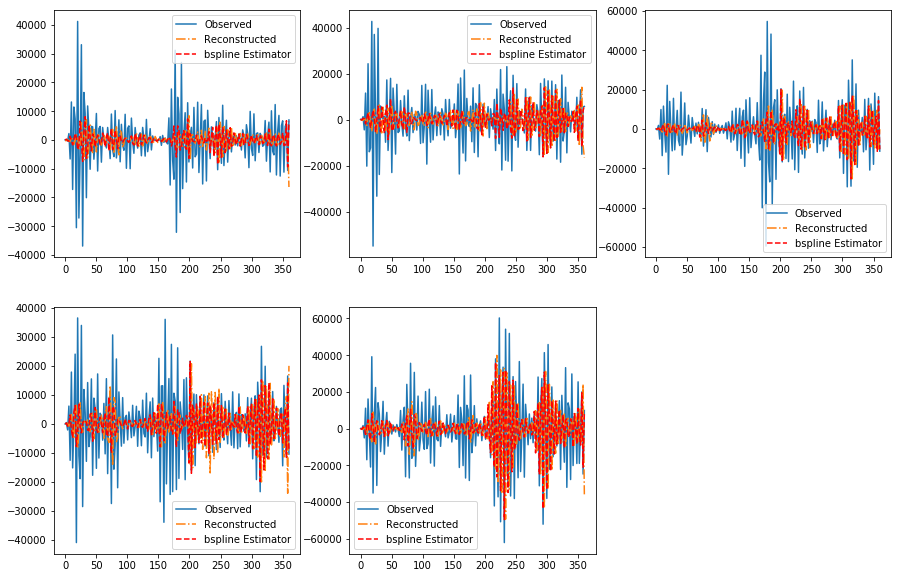

In [21]:
cfMRIDet.UpdateEcpts()
idxs = cfMRIDet.PlotRecCurve(is_smoothCurve=1)

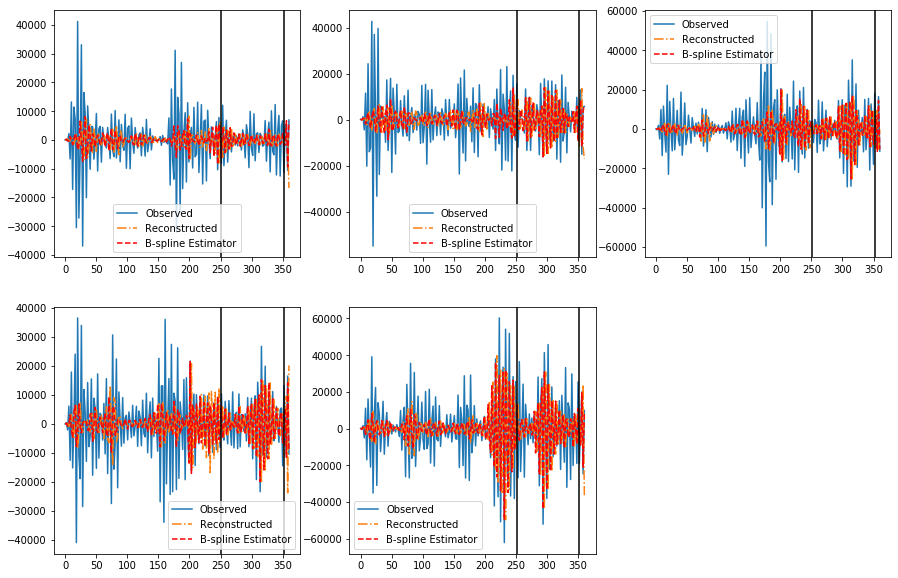

In [22]:
ecpts = cfMRIDet.ecpts
ecpts = ecpts.astype(np.int)
plt.figure(figsize=[15, 5*2])
for i, idx, in enumerate(idxs):
    plt.subplot(2, 3, i+1)
    plt.plot(cfMRIDet.ptime[:], cfMRIDet.nYmat[idx, :], "-", label="Observed")
    plt.plot(cfMRIDet.ptime[:], cfMRIDet.RecResCur.EstXmatRealOrg[idx, :], "-.", label="Reconstructed")
    plt.plot(cfMRIDet.ptime[:], cfMRIDet.Xmat[idx, :], "r--", label="B-spline Estimator")
    plt.legend()
    for ecpt in ecpts:
        plt.axvline(cfMRIDet.ptime[:][ecpt], color="black", label="Change Point")

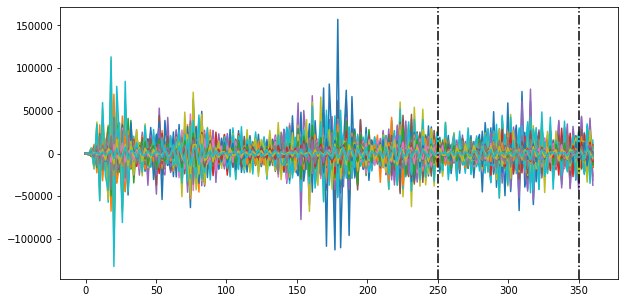

In [23]:
cfMRIDet.PlotEcpts()

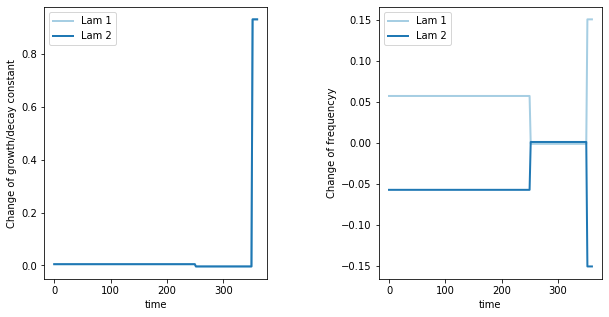

In [24]:
cfMRIDet.PlotEigenCurve()

# Demo result 3

In [25]:
idx = 160

cfMRI = fMRIs[0, idx]["fMRI"][:90, :]
chpffMRI= lfilter(hbp, 1, cfMRI)

result = results[idx]
tuningRes = result["rankRes"]
MSEs = np.array(tuningRes.MSEsKappas)
rIdx, kappaIdx = np.unravel_index(np.argmin(MSEs),MSEs.shape)
optRank = ranks[rIdx]
optKappa = kappas[kappaIdx]

cfMRIDet = TVDNDetect1(Ymat=chpffMRI, ReconXmat=ReconXmatNewBspStep, numStep=1, 
                        saveDir=None, dataType="fMRI", Lmin=4, downRate=4, fct=1, T=2, MaxM=20, 
                        fName="fMRI_HPF", r=optRank, kappa=optKappa, freq=0.5, lamb=1e-8,
                          decimateRate=None, is_detrend=True)
cfMRIDet()
cfMRIDet.TuningKappa(kappas)

The parameters for detection are:
{'Lmin': 4,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 4,
 'fName': 'fMRI_HPF',
 'fct': 1,
 'freq': 0.5,
 'is_detrend': True,
 'kappa': 1.99,
 'lamb': 1e-08,
 'nbasis': 10,
 'r': 10}


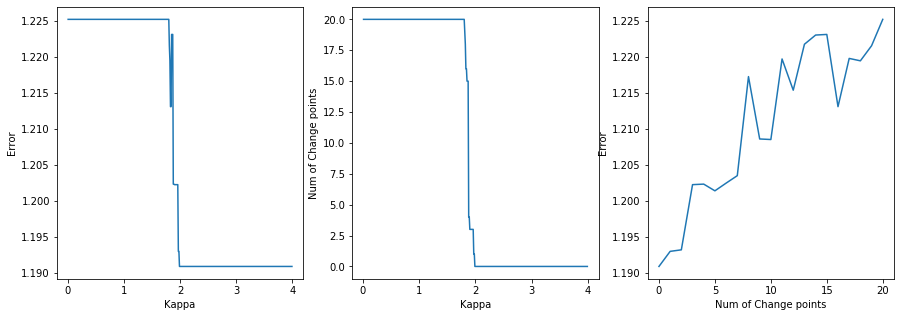

In [26]:
cfMRIDet.PlotKappaErrCurve()

The plot indices are [28 16 56 34  2].


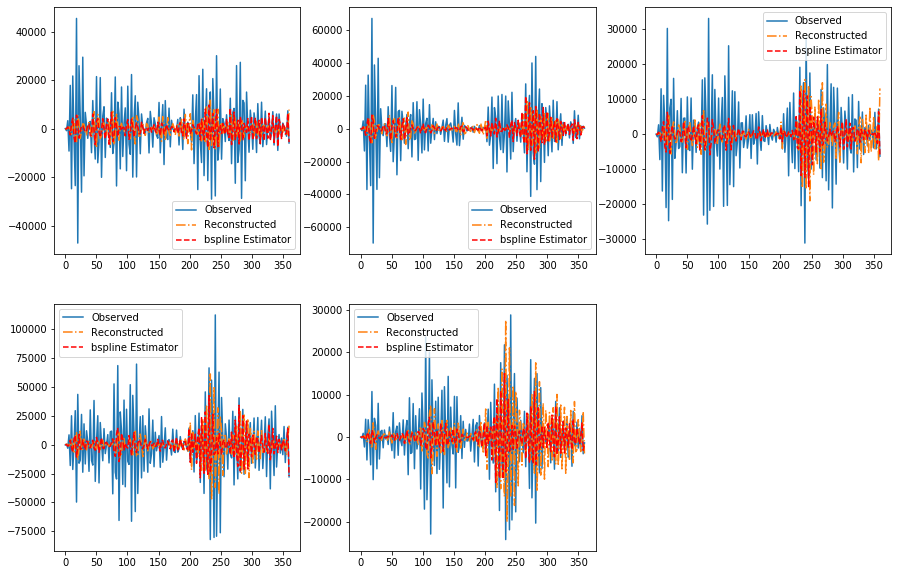

In [27]:
cfMRIDet.UpdateEcpts()
idxs = cfMRIDet.PlotRecCurve(is_smoothCurve=1)

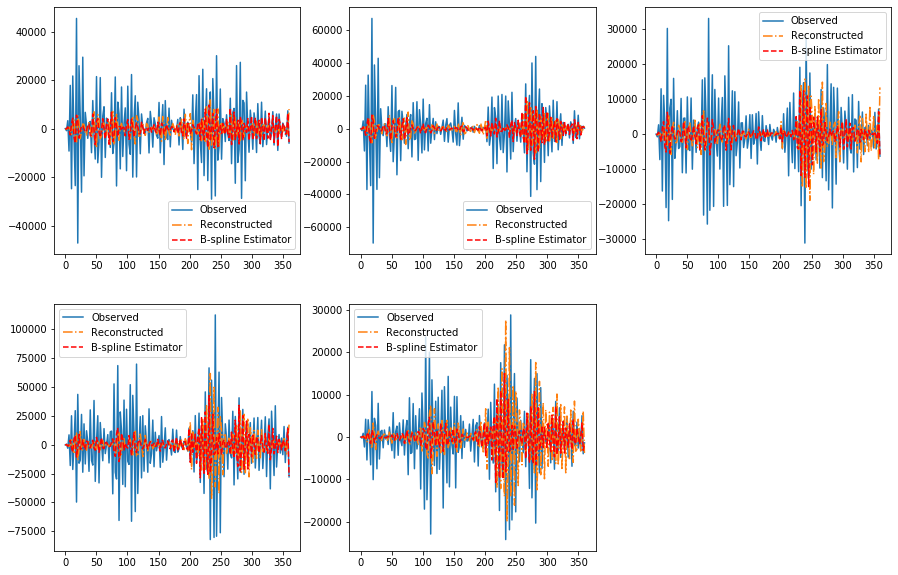

In [28]:
ecpts = cfMRIDet.ecpts
ecpts = ecpts.astype(np.int)
plt.figure(figsize=[15, 5*2])
for i, idx, in enumerate(idxs):
    plt.subplot(2, 3, i+1)
    plt.plot(cfMRIDet.ptime[:], cfMRIDet.nYmat[idx, :], "-", label="Observed")
    plt.plot(cfMRIDet.ptime[:], cfMRIDet.RecResCur.EstXmatRealOrg[idx, :], "-.", label="Reconstructed")
    plt.plot(cfMRIDet.ptime[:], cfMRIDet.Xmat[idx, :], "r--", label="B-spline Estimator")
    plt.legend()
    for ecpt in ecpts:
        plt.axvline(cfMRIDet.ptime[:][ecpt], color="black", label="Change Point")

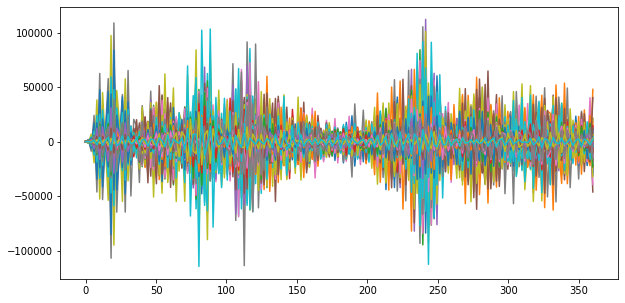

In [29]:
cfMRIDet.PlotEcpts()

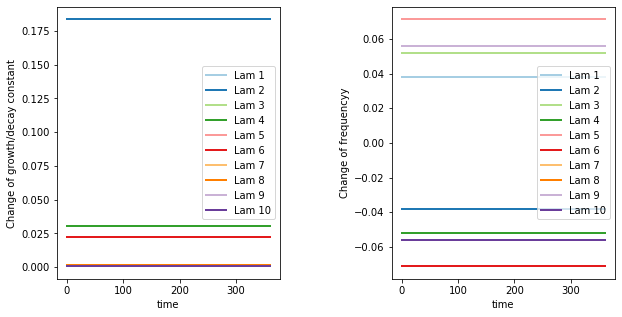

In [30]:
cfMRIDet.PlotEigenCurve()

# -------------------------------------------分割线---------------------------------------------

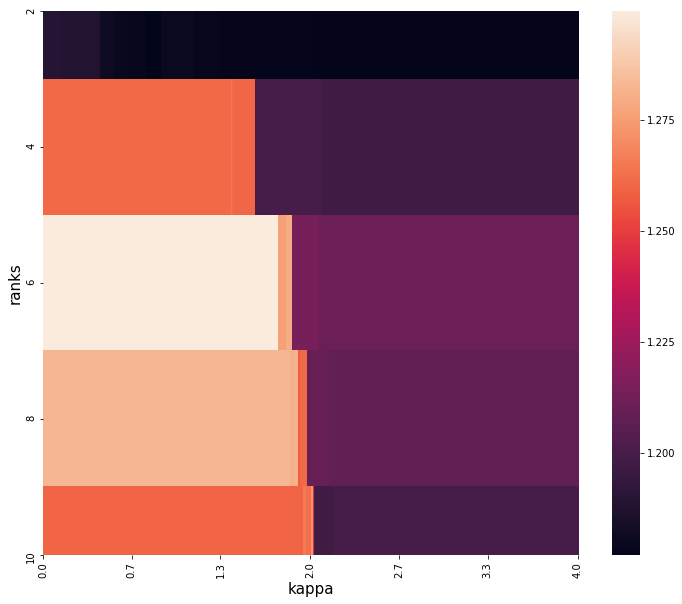

In [71]:
## Heatmap 
MSEs = np.array(res.MSEsKappas)
xticks_loc = np.linspace(0, len(kappas)-1, 7)
xticks_loc = xticks_loc.astype(np.int)
f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(MSEs, yticklabels=ranks, xticklabels=np.round(kappas[xticks_loc], 1))
plt.ylabel("ranks", fontsize=15)
plt.xlabel("kappa", fontsize=15)
_ = ax.set_xticks(xticks_loc)

In [76]:
print("The optimal kappas are:", fMRIDet.optKappa)
print("The optimal number of change point under the range of kappa we speicified is:", fMRIDet.optKappaOptNumChg)
print("The optimal number of change point is:", fMRIDet.optNumChg)

The optimal kappas are: 0.77
The optimal number of change point under the range of kappa we speicified is: 5
The optimal number of change point is: 5


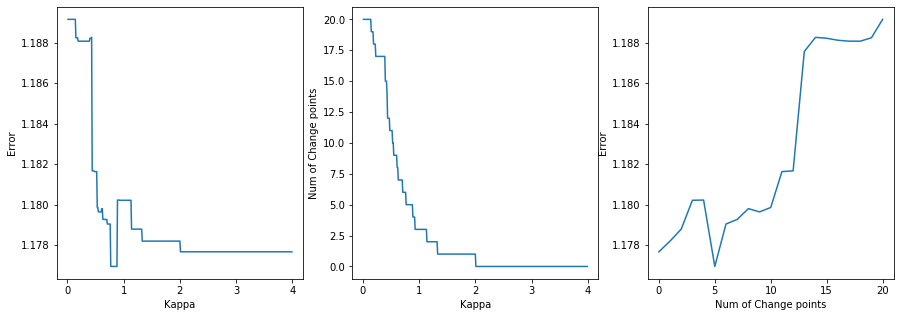

In [77]:
fMRIDet.PlotKappaErrCurve()

## 1.2 results under optimal kappa

In [78]:
fMRIDet.UpdateEcpts()

In [79]:
print(fMRIDet)

+-------------+----------------------------+--------------------+------+
| Num of CPTs |       Estiamted CPTs       |        MSE         | Rank |
+-------------+----------------------------+--------------------+------+
|      5      | [ 11.  79.  99. 122. 161.] | 1.1769386556281396 |  2   |
+-------------+----------------------------+--------------------+------+


### Reconstruct curve  by using the multiple-step Bsplien estimator 

The plot indices are [22 21 77 59 81].


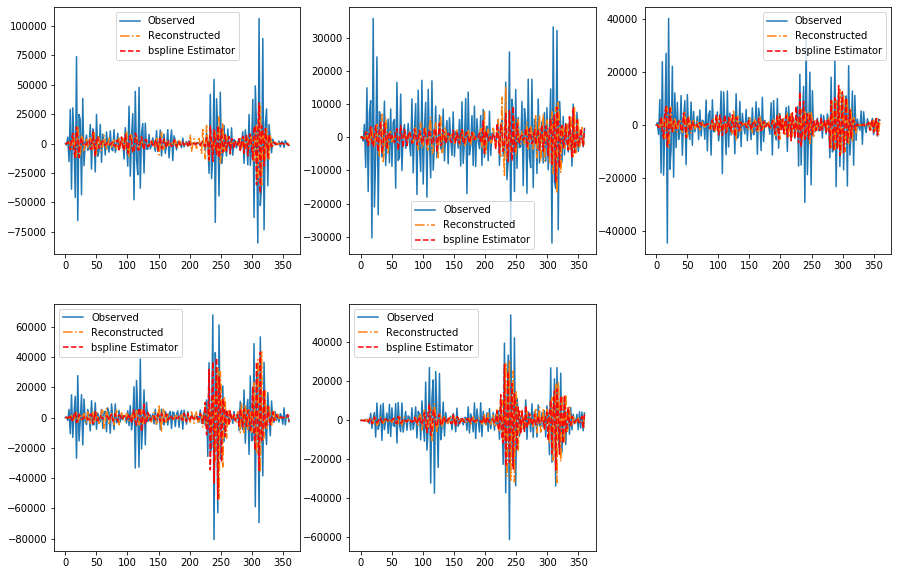

In [80]:
idxs = fMRIDet.PlotRecCurve(is_smoothCurve=1, saveFigPath=None)

no Bspline curve

The plot indices are [22 21 77 59 81].


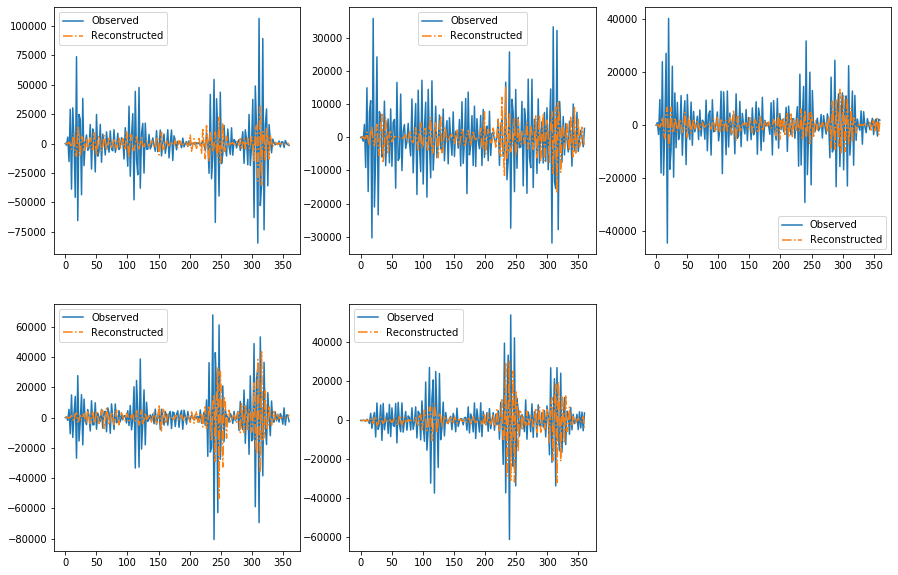

array([22, 21, 77, 59, 81])

In [81]:
fMRIDet.PlotRecCurve(idxs=idxs, is_smoothCurve=0, saveFigPath=None)

#### Restrict Y axis and No detrend

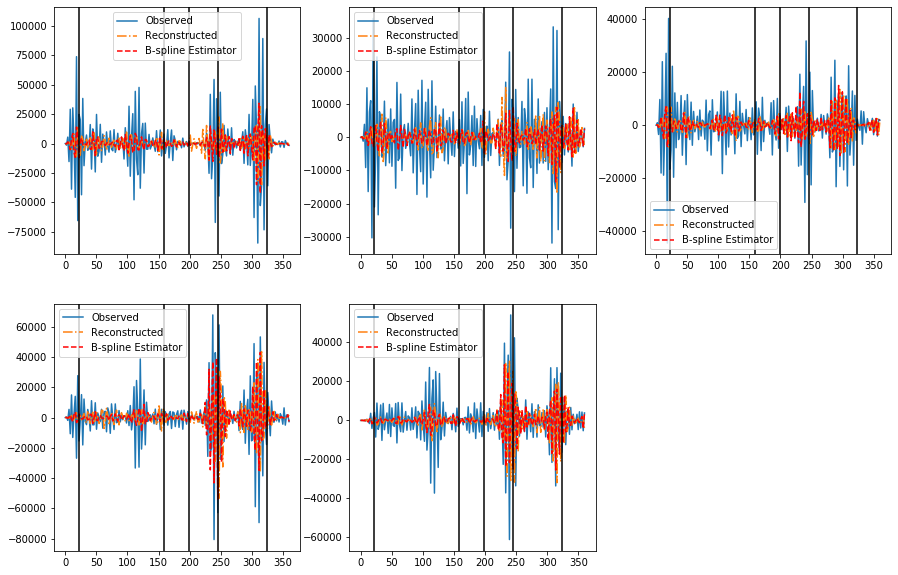

In [82]:
ecpts = fMRIDet.ecpts
ecpts = ecpts.astype(np.int)
plt.figure(figsize=[15, 5*2])
for i, idx, in enumerate(idxs):
    plt.subplot(2, 3, i+1)
    plt.plot(fMRIDet.ptime[:], fMRIDet.nYmat[idx, :], "-", label="Observed")
    plt.plot(fMRIDet.ptime[:], fMRIDet.RecResCur.EstXmatRealOrg[idx, :], "-.", label="Reconstructed")
    plt.plot(fMRIDet.ptime[:], fMRIDet.Xmat[idx, :], "r--", label="B-spline Estimator")
    plt.legend()
    for ecpt in ecpts:
        plt.axvline(fMRIDet.ptime[:][ecpt], color="black", label="Change Point")

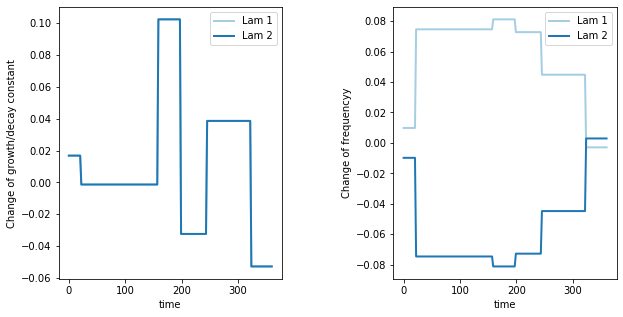

In [83]:
fMRIDet.PlotEigenCurve()

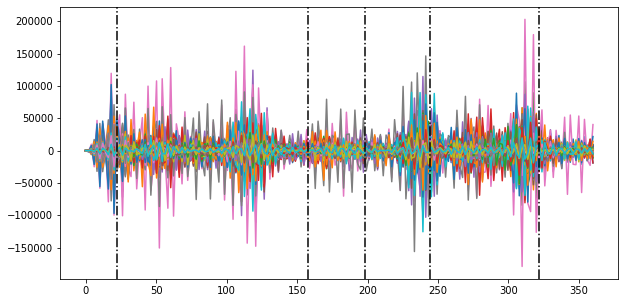

In [84]:
fMRIDet.PlotEcpts()